# DA Test for Ocare
Answered by Tanat Piumsuwan

### import libraries

In [58]:
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from collections import defaultdict

Given the Patient Value & Care Insight Analysis - the following patient dataset from a healthcare clinic, each row represents a patient's hospital admission, including demographics, medical condition, and billing data. 

In [59]:
df = pd.read_csv("healthcare_dataset.csv")
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [60]:
df.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


----
#### 1. Most Valuable Patients
Identify the top 3 patients by Billing Amount. Clean the names for proper capitalization (e.g., EMILY JOHNSOn → Emily Johnson) before displaying the result. 

In [61]:
# Clean names
df['Name'] = df["Name"].str.title()
df['Doctor'] = df["Doctor"].str.title()

# Get top patients
top_patients = df.sort_values(by='Billing Amount', ascending=False).head(3)


print(top_patients)


                Name  Age  Gender Blood Type Medical Condition  \
36349  Todd Carrillo   51  Female         A+      Hypertension   
51313    Karen Kline   74  Female        AB+            Cancer   
34613    Karen Kline   79  Female        AB+            Cancer   

      Date of Admission             Doctor          Hospital  \
36349        2023-09-08   Kathleen Griffin     Griffin Group   
51313        2021-06-19  Dr. Joseph Gordon  Hernandez-Morton   
34613        2021-06-19  Dr. Joseph Gordon  Hernandez-Morton   

      Insurance Provider  Billing Amount  Room Number Admission Type  \
36349         Blue Cross    52764.276736          209       Elective   
51313   UnitedHealthcare    52373.032374          181         Urgent   
34613   UnitedHealthcare    52373.032374          181         Urgent   

      Discharge Date  Medication  Test Results  
36349     2023-10-04   Ibuprofen        Normal  
51313     2021-07-03  Penicillin  Inconclusive  
34613     2021-07-03  Penicillin  Inconclu

The top three valuable patients are:

In [62]:
print(top_patients[['Name', 'Billing Amount']])

                Name  Billing Amount
36349  Todd Carrillo    52764.276736
51313    Karen Kline    52373.032374
34613    Karen Kline    52373.032374


----
#### Insight Discovery
Based on the small dataset: What medical conditions are associated with higher billing amounts? Are there any patterns in admission type or test results that the hospital should be aware of?  


I use correlation for numerical values (extract date into years month day first), and ANOVA for categorical values. However, patient's name is obviously should not be considered for association tests. Starts by reprocessing the date data:

In [63]:
df.drop(columns = ["Name"], inplace = True)

# Convert to datetime (if not already done)
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# Extract separate date components for Admission
df['Admission Year'] = df['Date of Admission'].dt.year
df['Admission Month'] = df['Date of Admission'].dt.month
df['Admission DayOfWeek'] = df['Date of Admission'].dt.dayofweek  # Monday=0, Sunday=6
df['Admission DayOfYear'] = df['Date of Admission'].dt.dayofyear
df['Days Since First Admission'] = (df['Date of Admission'] - df['Date of Admission'].min()).dt.days

# Extract separate date components for Discharge
df['Discharge Year'] = df['Discharge Date'].dt.year
df['Discharge Month'] = df['Discharge Date'].dt.month
df['Discharge DayOfWeek'] = df['Discharge Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Discharge DayOfYear'] = df['Discharge Date'].dt.dayofyear
df['Days Since First Discharge'] = (df['Discharge Date'] - df['Discharge Date'].min()).dt.days

# Calculate total days admitted (length of stay)
df['Total Days Admitted'] = (df['Discharge Date'] - df['Date of Admission']).dt.days


Then roughly check the distributions:

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


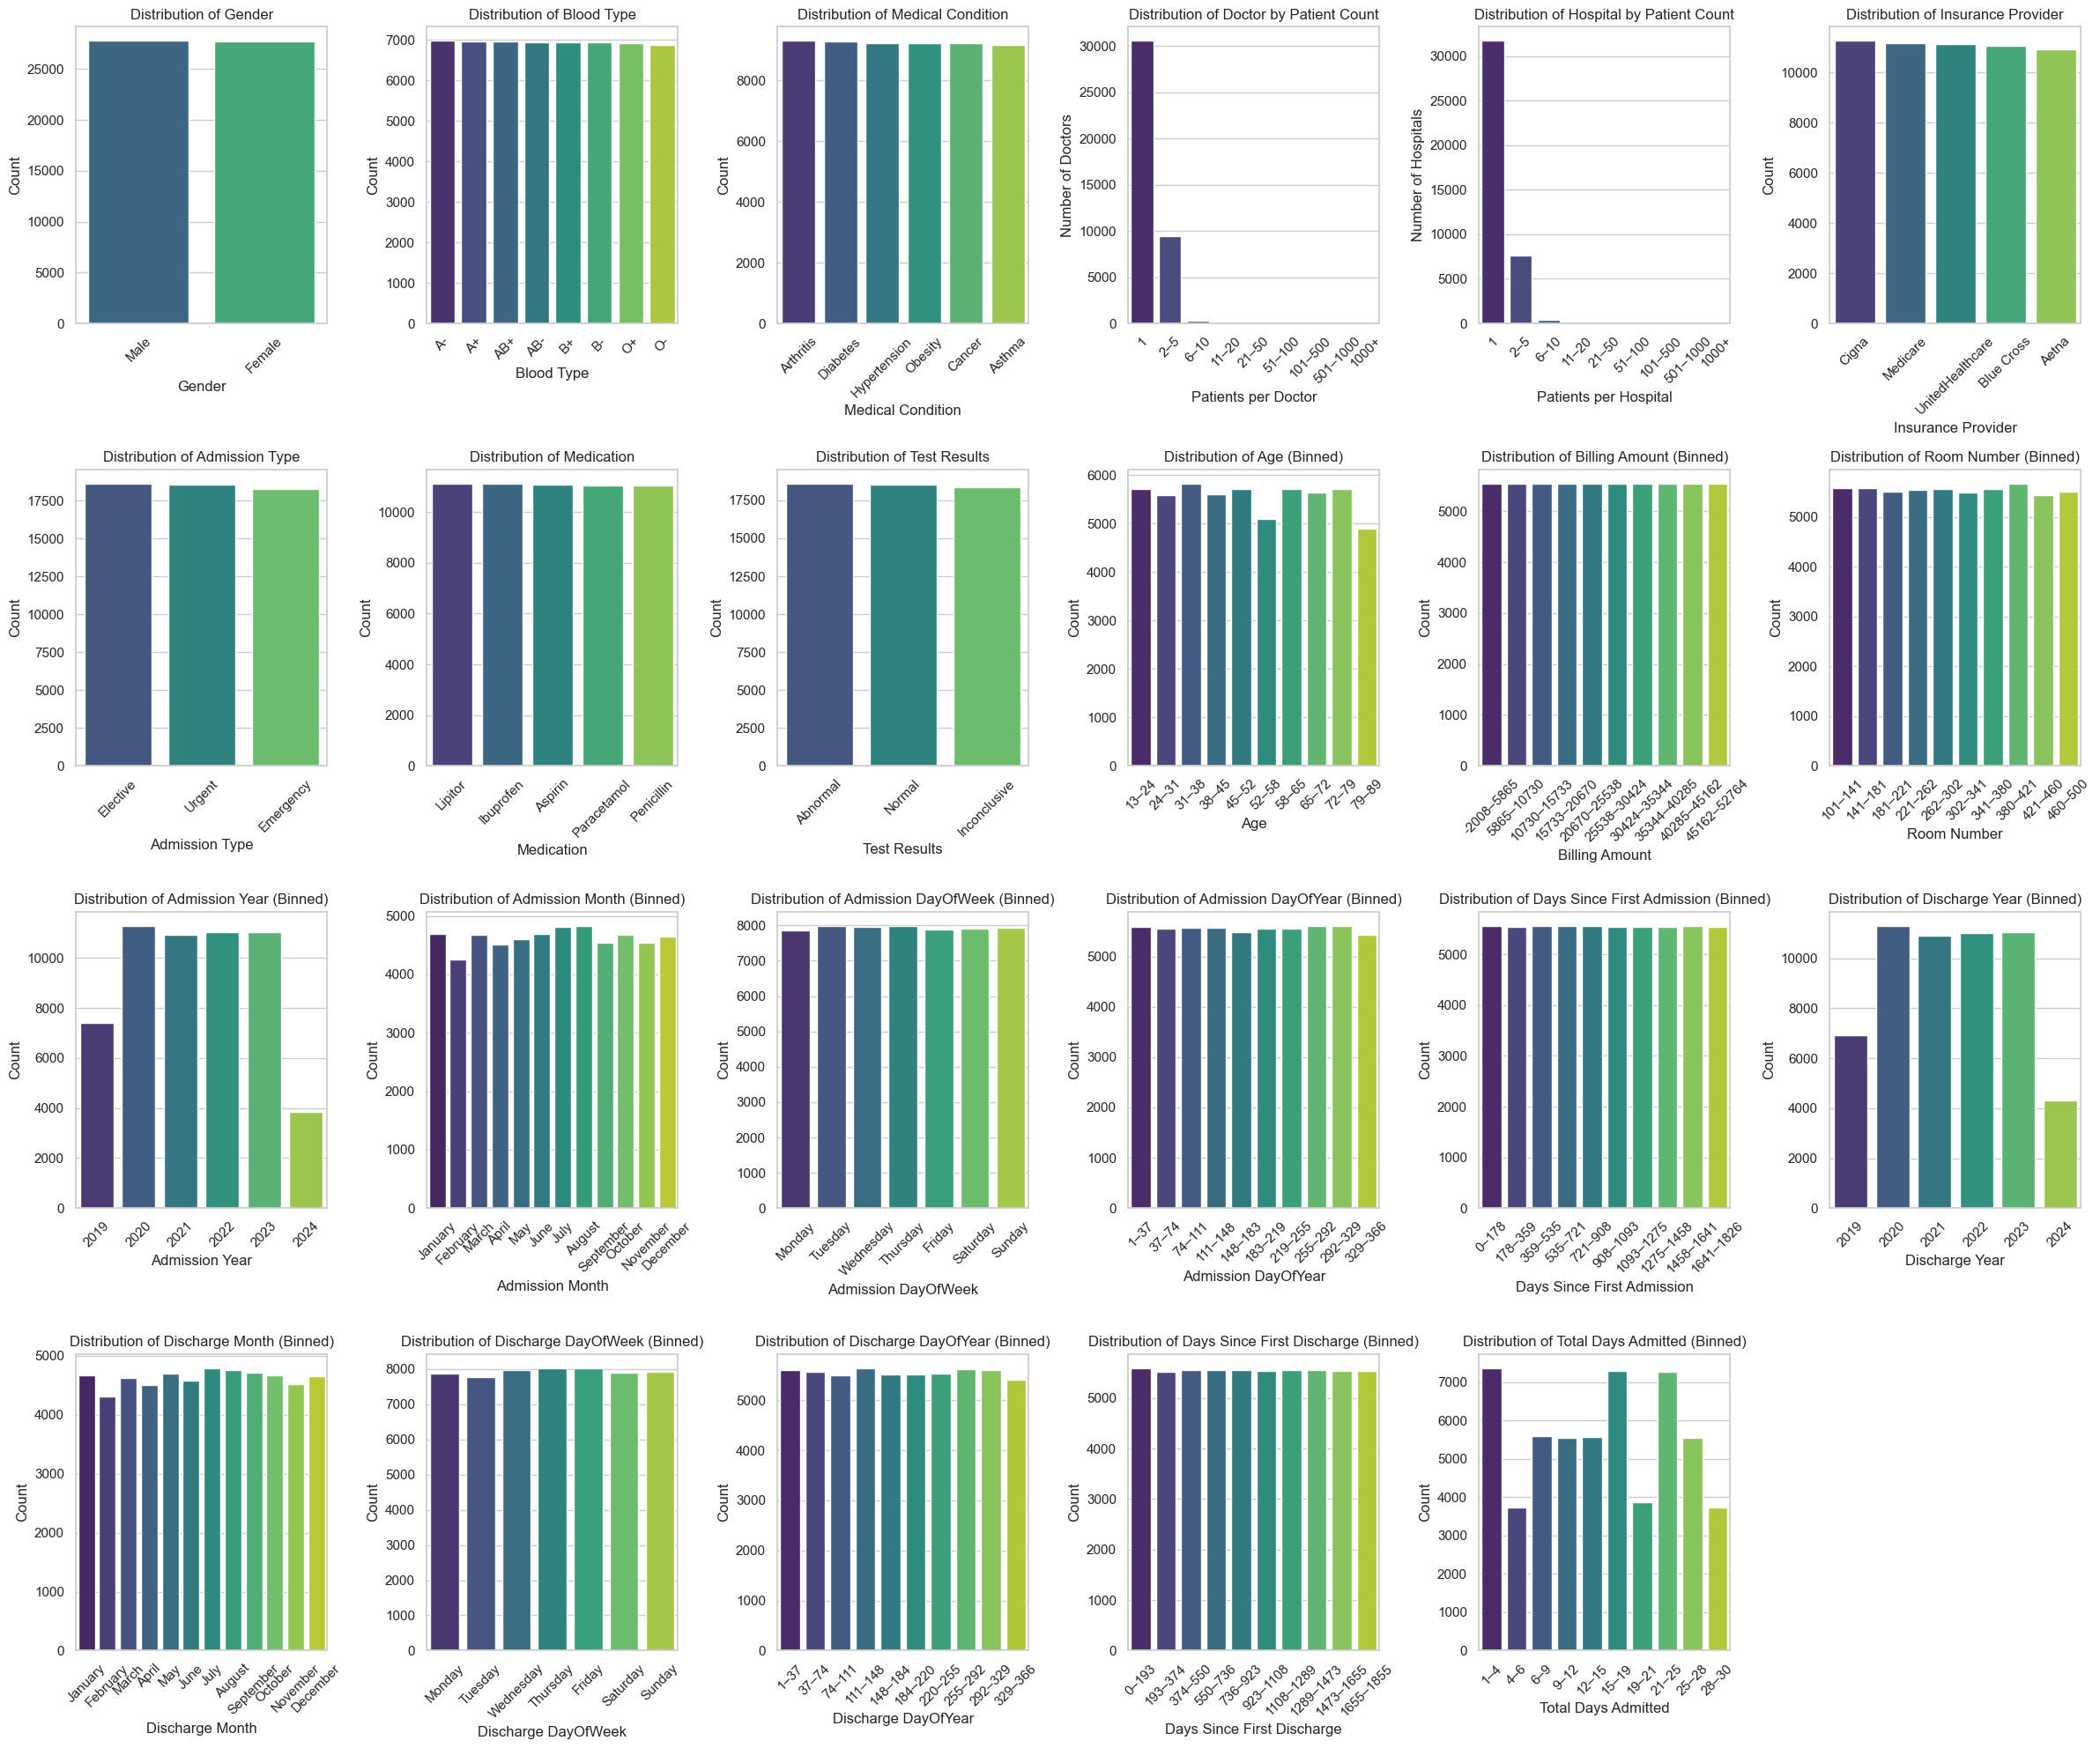

In [89]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
num_cols = df.select_dtypes(include=['number']).columns  # numeric columns to bin

n_cols = 6
n_rows = int(np.ceil((len(cat_cols) + len(num_cols)) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 5 * n_rows))
axes = axes.flatten()

def bin_numeric_series(series, n_bins=10, fixed_bins=None, fixed_labels=None):
    if fixed_bins is not None:
        # Use fixed bins and labels (right=False to have intervals like [a,b))
        return pd.cut(series, bins=fixed_bins, labels=fixed_labels, include_lowest=True, right=False)
    else:
        bins = np.quantile(series.dropna(), np.linspace(0, 1, n_bins + 1))
        bins = np.unique(bins)  # remove duplicates if any quantiles equal
        n_actual_bins = len(bins) - 1
        labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(n_actual_bins)]
        return pd.cut(series, bins=bins, labels=labels, include_lowest=True, duplicates='drop')


year_fixed_bins = [2018.5, 2019.5, 2020.5, 2021.5, 2022.5, 2023.5, 2024.5]
year_fixed_labels = [str(year) for year in range(2019, 2025)]
    
for i, col in enumerate(list(cat_cols) + list(num_cols)):
    if col in ["Doctor", "Hospital"]:
        # Count patients per doctor/hospital
        counts = df.groupby(col).size().reset_index(name="Patient Count")

        # Bin counts for Doctor/Hospital
        max_count = counts["Patient Count"].max()
        bins = [0, 1, 5, 10, 20, 50, 100, 500, 1000, max(max_count + 1, 1001)]
        labels = ["1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–500", "501–1000", "1000+"]

        counts["Bin"] = pd.cut(counts["Patient Count"], bins=bins, labels=labels, right=True)
        bin_counts = counts["Bin"].value_counts().sort_index()

        sns.barplot(
            x=bin_counts.index,
            y=bin_counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} by Patient Count")
        axes[i].set_xlabel(f"Patients per {col}")
        axes[i].set_ylabel(f"Number of {col}s")
        axes[i].tick_params(axis='x', rotation=45)

    elif col in num_cols:
        if col in ['Admission DayOfWeek', 'Discharge DayOfWeek']:
            dayofweek_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            fixed_bins = list(range(0, 8))  # 0 to 7
            fixed_labels = dayofweek_labels
            binned = bin_numeric_series(df[col], fixed_bins=fixed_bins, fixed_labels=fixed_labels)
        elif col in ['Admission Month', 'Discharge Month']:
            month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 
                            'July', 'August', 'September', 'October', 'November', 'December']

            fixed_bins = list(range(1, 14))  # 1 to 13, so 12 is included in last bin [12, 13)
            fixed_labels = month_labels
            binned = bin_numeric_series(df[col], fixed_bins=fixed_bins, fixed_labels=fixed_labels)
        elif col in ['Admission Year', 'Discharge Year']:
            binned = bin_numeric_series(df[col], fixed_bins=year_fixed_bins, fixed_labels=year_fixed_labels)
        else:
            binned = bin_numeric_series(df[col], n_bins=10)

        counts = binned.value_counts().sort_index()
        sns.barplot(
            x=counts.index.astype(str),
            y=counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} (Binned)")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

    else:
        # For small cardinality categorical variables
        counts = df[col].value_counts().reset_index()
        counts.columns = [col, "Count"]

        sns.barplot(
            x=col,
            y="Count",
            data=counts,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

At first glance, data seems to have balance distributions, apart from patients per doctor and patients per hospital. There is an interesting distribution for total days admitted. This should be investigated in latter parts. Next, bar plot of billing amount for categorical variables

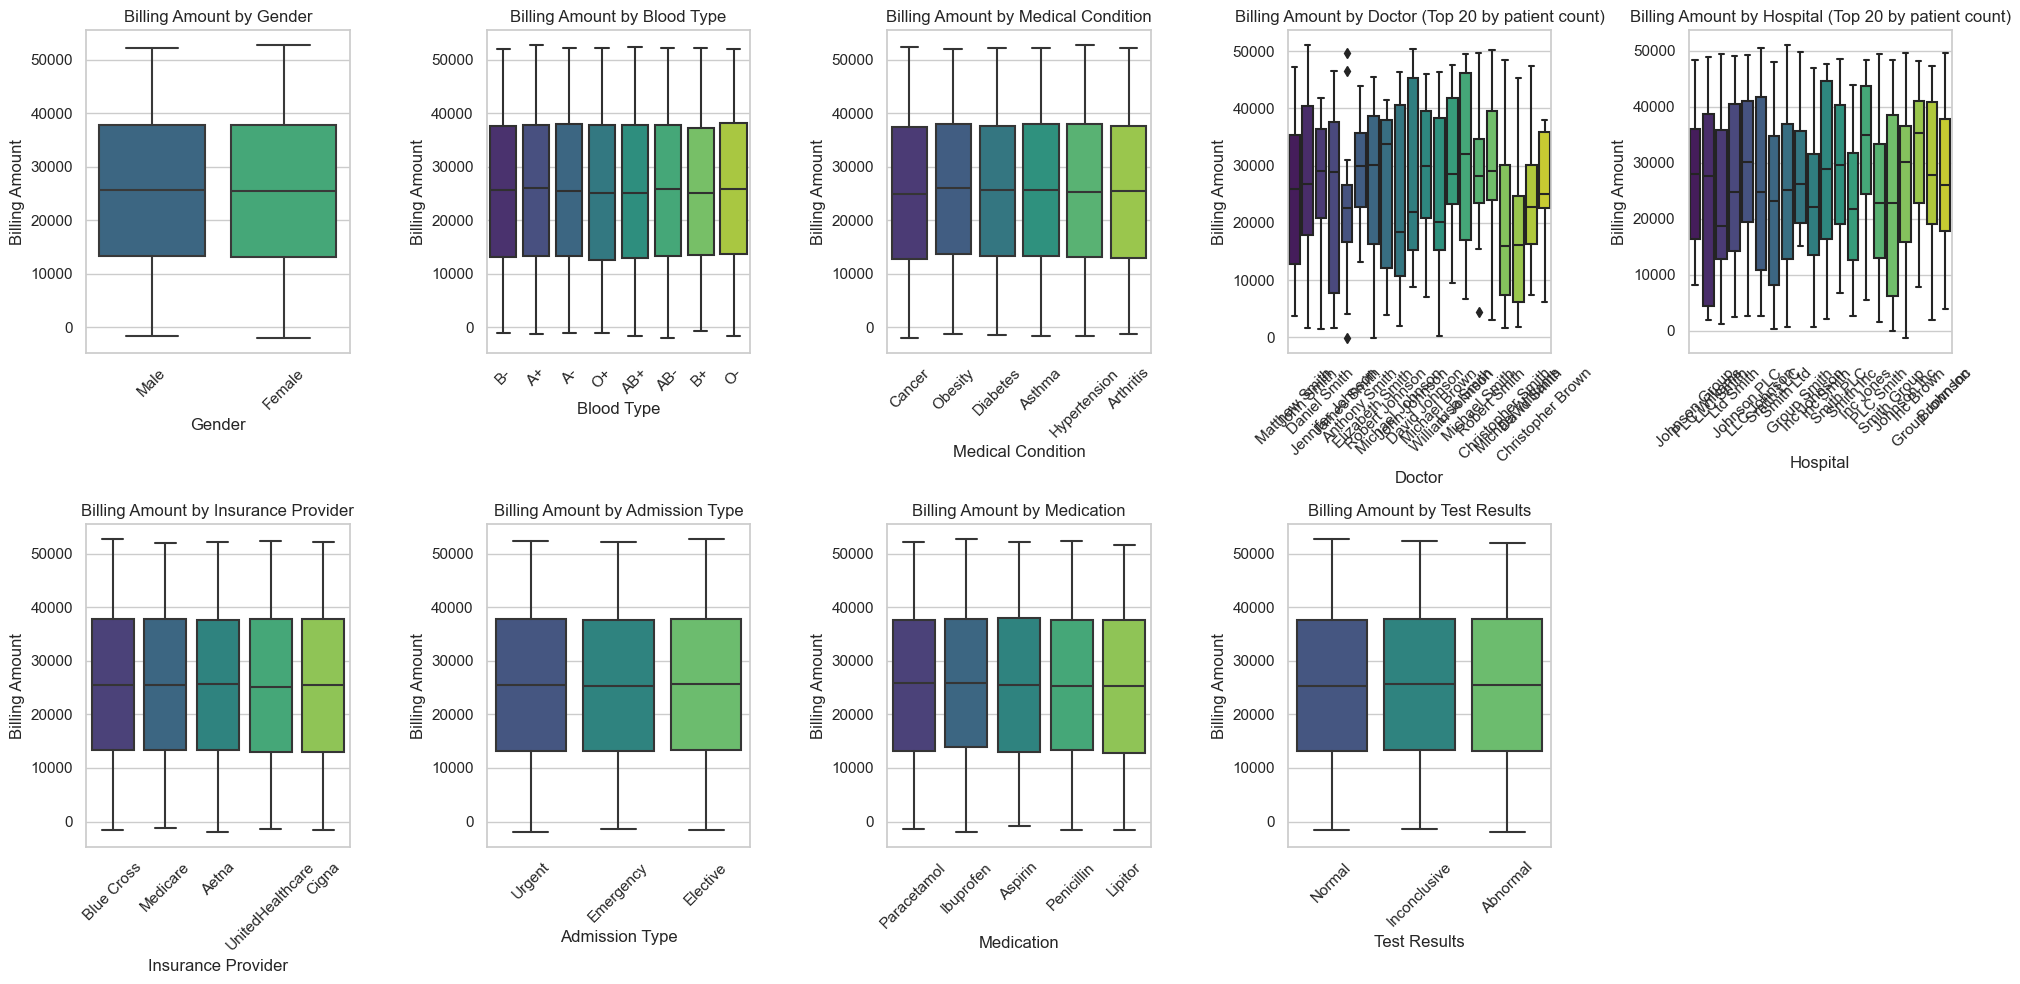

In [65]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

n_cols = 5
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):

    if col in ['Doctor', 'Hospital']:
        # Get top 20 by patient count
        top_20 = (
            df.groupby(col).size()
            .sort_values(ascending=False)
            .head(20)
            .index
            .tolist()
        )
        plot_df = df[df[col].isin(top_20)][[col, 'Billing Amount']].dropna()

        sns.boxplot(x=col, y='Billing Amount', data=plot_df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Billing Amount by {col} (Top 20 by patient count)')
    else:
        plot_df = df[[col, 'Billing Amount']].dropna()
        sns.boxplot(x=col, y='Billing Amount', data=plot_df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Billing Amount by {col}')

    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Billing Amount')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

For the bar plot alone, there are no visible trends. Next, let's move on to tests for associations. For numerical values, check correlation:

In [66]:
# Numeric correlation with Billing Amount
print("Correlation (Pearson) with Billing Amount:")
print(df.select_dtypes(include=['number']).corr()['Billing Amount'].sort_values(ascending=False))

Correlation (Pearson) with Billing Amount:
Billing Amount                1.000000
Discharge Month               0.007676
Discharge DayOfYear           0.007321
Admission Month               0.004419
Admission DayOfYear           0.003849
Days Since First Admission   -0.001057
Days Since First Discharge   -0.001149
Admission Year               -0.001763
Discharge Year               -0.002513
Room Number                  -0.002943
Age                          -0.003832
Admission DayOfWeek          -0.003888
Discharge DayOfWeek          -0.004462
Total Days Admitted          -0.005602
Name: Billing Amount, dtype: float64


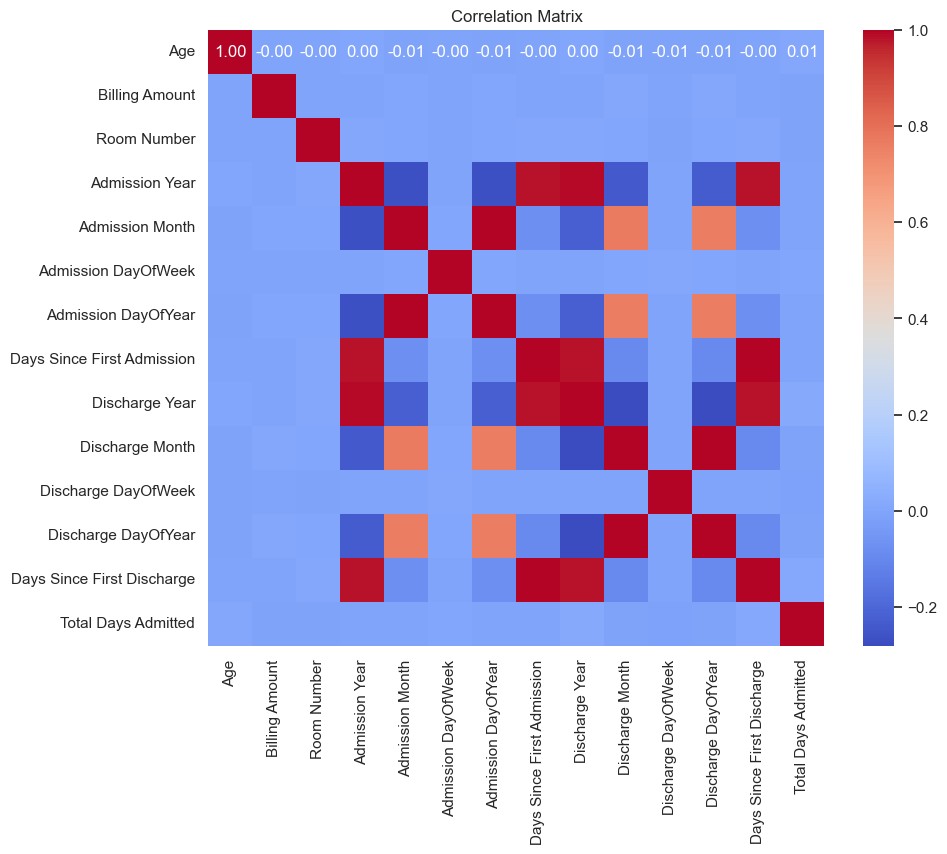

In [67]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

I found no significant correlations between billing amount and other numerical variables. Next, the categorical values:

In [68]:
from scipy import stats
import pandas as pd

def get_anova_pvalues(df, cat_cols, target_col='Billing Amount'): # get ANOVA p-value compared to billing amount
    results = {}
    for cat_col in cat_cols:
        groups = [df[df[cat_col] == val][target_col] for val in df[cat_col].dropna().unique()]
        
        if len(groups) < 2:
            results[cat_col] = None  # Not enough groups
            continue
        
        f_stat, p_val = stats.f_oneway(*groups)
        results[cat_col] = p_val
    
    # Convert to DataFrame for easy viewing
    pvalue_df = pd.DataFrame.from_dict(results, orient='index', columns=['ANOVA_p_value'])
    return pvalue_df

# Select categorical columns automatically
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Running ANOVA for all categorical values is quite long; thus, I save the calculated value as 'anova_results.csv'
# Folder for saving
save_folder = "saved_results"
os.makedirs(save_folder, exist_ok=True)

filename = os.path.join(save_folder, 'anova_results.csv')

if os.path.exists(filename):
    # Load saved results
    anova_results = pd.read_csv(filename, index_col=0)
    print("Loaded ANOVA results from file.")
else:
    # Compute and save results
    anova_results = get_anova_pvalues(df, categorical_cols)
    anova_results.to_csv(filename)
    print("Computed and saved ANOVA results.")

print(anova_results)


Loaded ANOVA results from file.
                    ANOVA_p_value
Gender               2.554374e-01
Blood Type           3.240196e-01
Medical Condition    5.559198e-02
Doctor              3.219070e-249
Hospital            2.485204e-236
Insurance Provider   7.569849e-01
Admission Type       7.524603e-01
Medication           3.360324e-01
Test Results         5.289806e-01


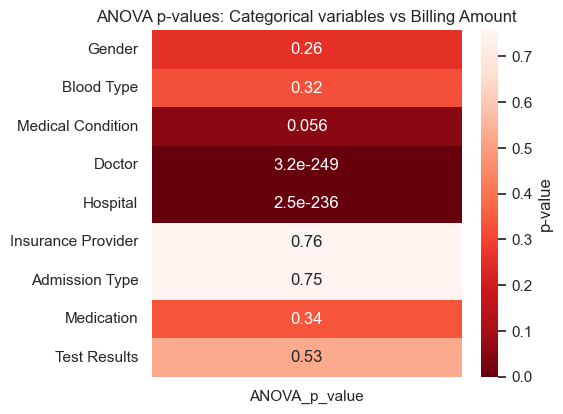

In [69]:
plt.figure(figsize=(5, len(anova_results)*0.5))
sns.heatmap(anova_results[['ANOVA_p_value']], annot=True, cmap='Reds_r', cbar_kws={'label': 'p-value'})
plt.title('ANOVA p-values: Categorical variables vs Billing Amount')
plt.show()


ANOVA test suggest that Doctor and Hospital have a strong association to the patient billing amount under the significance level = 0.05, followed closely by the medical condition under the significant level = 0.1. Next, test for cross associations between categorical variables. However, the very low p-value than usual for Docter and Hospital could be due to the fact that the number of unique doctor and hospital is close to the sample size:

In [70]:
print("Number of unique doctors in this dataset: ", len(df["Doctor"].unique()))
print("Number of unique hospitals in this dataset: ", len(df["Hospital"].unique()))
print("Number of samples in this dataset: ", len(df))

Number of unique doctors in this dataset:  40341
Number of unique hospitals in this dataset:  39876
Number of samples in this dataset:  55500


We can see that there are too many different doctors and hospitals for this dataset. Although ANOVA suggests that Doctor (p ≈ 3.2×10⁻²⁴⁹) and Hospital (p ≈ 2.5×10⁻²³⁶) are statistically extremely significant, the following points should be considered:

- Each category often has very few samples (many possibly only 1–2 patients).
- With 40,000+ categories in a dataset of 55,000 rows, ANOVA will pick up any tiny difference as “significant” — even random noise — simply because the F-test denominator (within-group variance) becomes very small for singleton groups.
- This is likely a cardinality-driven artifact rather than evidence of a meaningful billing trend tied to specific doctors or hospitals.

Furthermore, the observed differences could be due to the fact that different doctors and hospitals handle vastly different cases and patient profiles. The supposed association, if it exists, could be due to confounding variables such as patient condition, admission type, etc.

Therefore, it is reasonable to move on and check the next variables.

In [71]:
# Select categorical columns automatically
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
what_to_remove = ['Doctor', 'Hospital']
for item in what_to_remove:
    categorical_cols.remove(item) # Exclusively exclude patient's name, doctor's name, hospital name
print(categorical_cols)

['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']


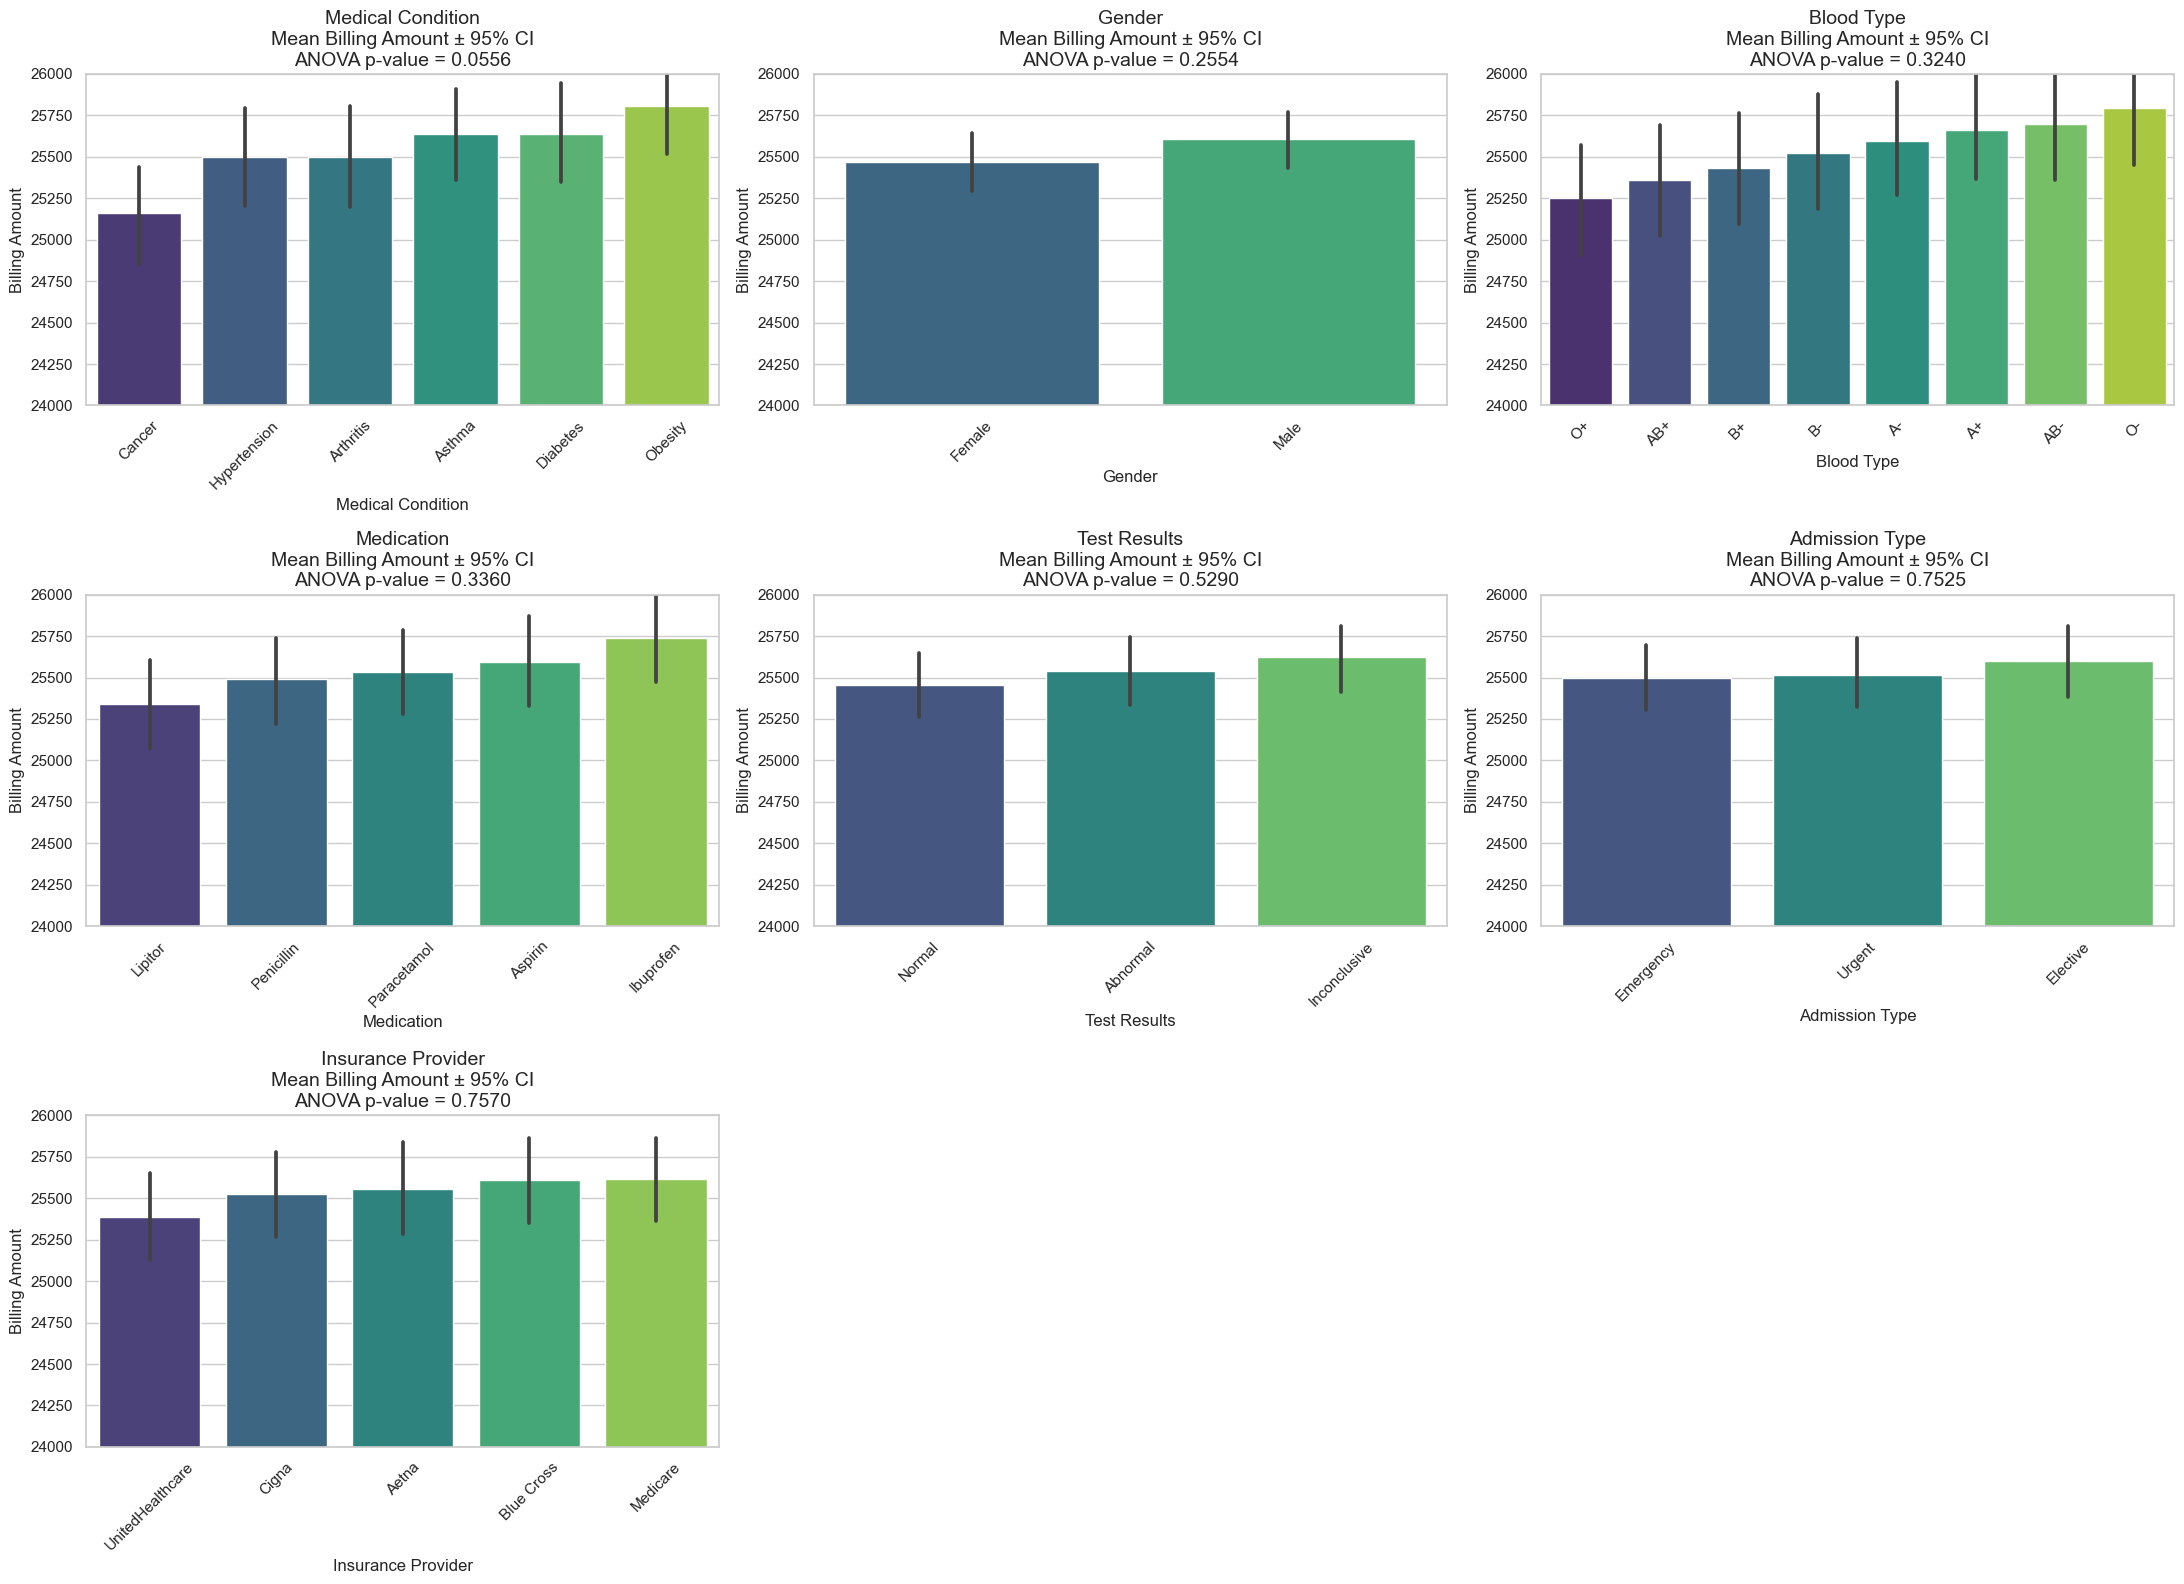

In [72]:
# Sort vars_to_plot by ANOVA p-value
vars_to_plot = [
    "Medical Condition",
    "Gender",
    "Blood Type",
    "Insurance Provider",
    "Admission Type",
    "Medication",
    "Test Results"
]

# Sort vars_to_plot by ANOVA p-value
vars_to_plot_sorted = anova_results.loc[vars_to_plot].sort_values(by="ANOVA_p_value").index.tolist()

sns.set_theme(style="whitegrid")

# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(22, 16))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot_sorted):
    # Sort categories by mean billing amount
    order = df.groupby(var)["Billing Amount"].mean().sort_values().index

    p_val = anova_results.loc[var, "ANOVA_p_value"]
    sns.barplot(
        data=df,
        x=var,
        y="Billing Amount",
        order=order,
        errorbar=('ci', 95),
        palette="viridis",
        ax=axes[i]
    )
    
    axes[i].set_title(f"{var}\nMean Billing Amount ± 95% CI\nANOVA p-value = {p_val:.4f}", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(24000, 26000)  # Set y-axis limits here

# Remove unused axes
for j in range(len(vars_to_plot_sorted), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The slight observable trends in **Medical Condition** align with the ANOVA result indicating a potential association with billing amount. Next, I analyze other variables:

1. **Gender, Blood Type, Medication, Test Results** (p-values ≈ 0.25–0.53):  
   - ANOVA indicates no strong statistical evidence of differences in billing amounts across these groups.  
   - However, the distribution plots with 95% confidence intervals show some subtle patterns worth noting.  
   - In practice, any observed associations might be indirect, possibly reflecting underlying links to medical conditions. Therefore, these variables should not be completely dismissed.

2. **Insurance Provider, Admission Type** (high p-values ≈ 0.75):  
   - ANOVA results suggest no meaningful differences in mean billing amounts across categories.  
   - For **Admission Type**, there is a slight increase in billing for elective admissions compared to urgent or emergency cases. This might be confounded by socioeconomic factors, as elective admissions may correlate with wealthier patients.  
   - For **Insurance Provider**, observed trends may reflect differences in customer demographics or other external factors. Given the lack of statistical support, we should refrain from concluding any direct association with billing amounts.


Lastlt, check for observable cross associations:

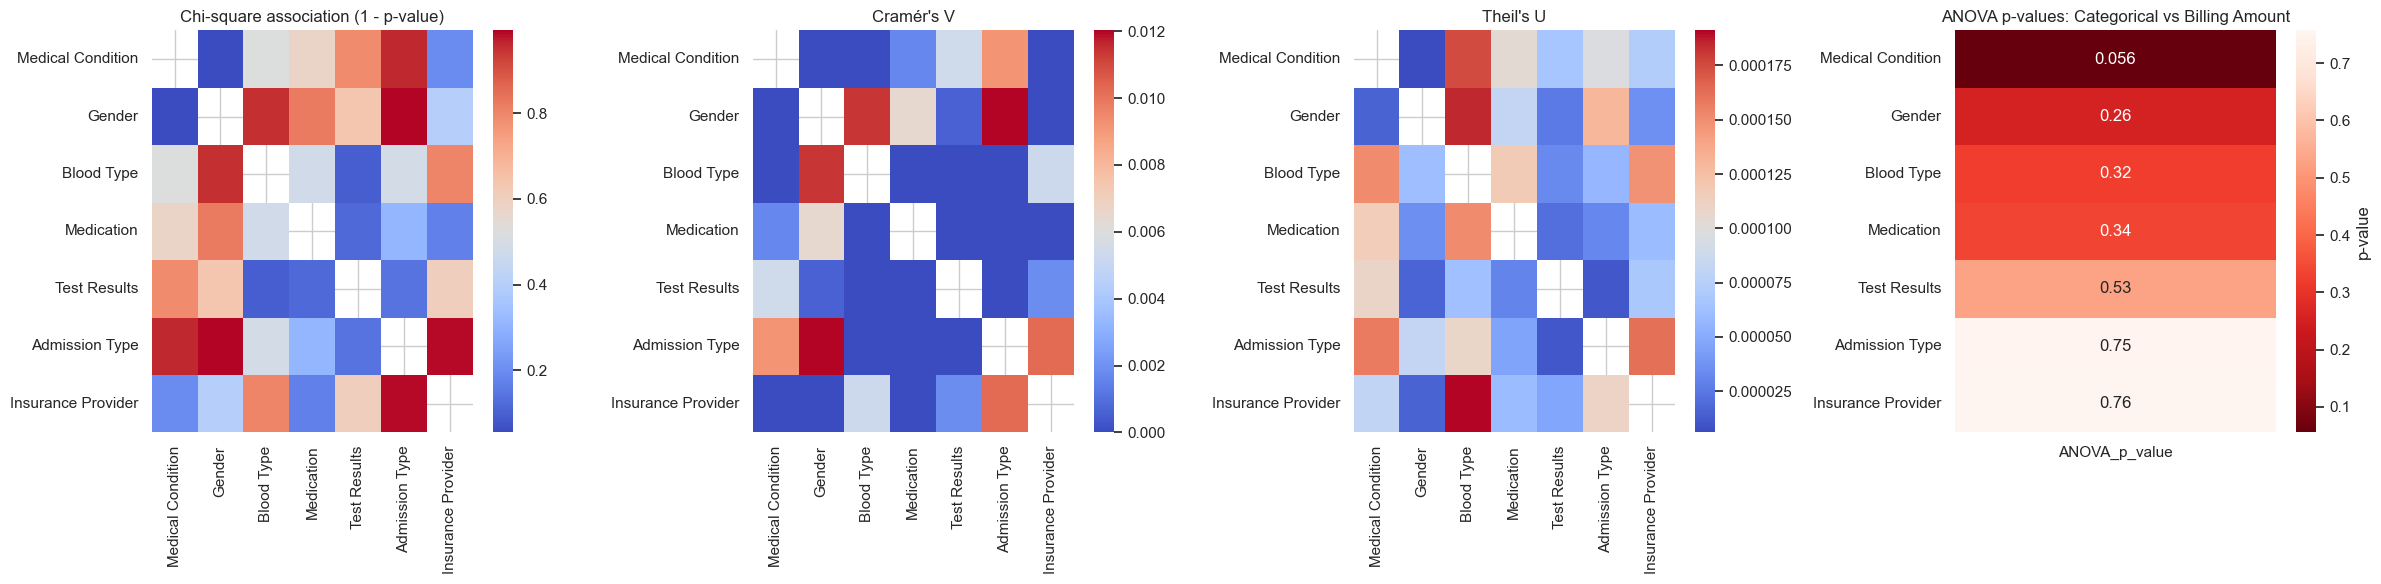

In [73]:
# ======================
# Helper functions (same as your code)
# ======================
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def conditional_entropy(x, y):
    y_counter = y.value_counts()
    xy_counter = pd.crosstab(index=x, columns=y)
    total_occurrences = y_counter.sum()
    entropy = 0.0
    for col in xy_counter.columns:
        p_y = y_counter[col] / total_occurrences
        sub_x = xy_counter[col] / y_counter[col]
        entropy += p_y * -(sub_x[sub_x > 0] * np.log2(sub_x[sub_x > 0])).sum()
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counts = x.value_counts(normalize=True)
    s_x = -(x_counts * np.log2(x_counts)).sum()
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
# ======================
# Main computation
# ======================
def association_matrices(df, categorical_cols):
    chi2_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                               index=categorical_cols, columns=categorical_cols)
    cramers_matrix = chi2_matrix.copy()
    theils_matrix = chi2_matrix.copy()

    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                chi2_matrix.loc[col1, col2] = np.nan
                cramers_matrix.loc[col1, col2] = np.nan
                theils_matrix.loc[col1, col2] = np.nan
            else:
                confusion = pd.crosstab(df[col1], df[col2])
                chi2, p, _, _ = chi2_contingency(confusion)
                chi2_matrix.loc[col1, col2] = p
                cramers_matrix.loc[col1, col2] = cramers_v(confusion)
                theils_matrix.loc[col1, col2] = theils_u(df[col1], df[col2])

    return chi2_matrix, cramers_matrix, theils_matrix

# ======================
# Execution & Sorting
# ======================
anova_results = get_anova_pvalues(df, categorical_cols)

# Sort columns by ascending ANOVA p-value
sorted_cols = anova_results.sort_values(by = 'ANOVA_p_value', ascending=True).index.tolist()

chi2_matrix, cramers_matrix, theils_matrix = association_matrices(df, categorical_cols)

# Reorder matrices by sorted columns (both rows and cols)
chi2_matrix_sorted = chi2_matrix.loc[sorted_cols, sorted_cols]
cramers_matrix_sorted = cramers_matrix.loc[sorted_cols, sorted_cols]
theils_matrix_sorted = theils_matrix.loc[sorted_cols, sorted_cols]

anova_sorted = anova_results.loc[sorted_cols]

# ========= Plotting =========
chi2_scaled = 1 - chi2_matrix_sorted  # Reverse scale for chi2 p-values

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

sns.heatmap(chi2_scaled, annot=False, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Chi-square association (1 - p-value)")

sns.heatmap(cramers_matrix_sorted, annot=False, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Cramér's V")

sns.heatmap(theils_matrix_sorted, annot=False, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Theil's U")

sns.heatmap(anova_sorted, annot=True, cmap='Reds_r', cbar_kws={'label': 'p-value'}, ax=axes[3])
axes[3].set_title('ANOVA p-values: Categorical vs Billing Amount')

plt.tight_layout()
plt.show()


Despite Chi square suggesting cross-association exists, low overall **Cramer's V** and **Theil's U** confirm that such associations are weak and may not be significant.

Therefore, in conclusion,based on the analysis:

1. **Numerical features**, including one derived from admission and discharged date, show no significant impact on billing amount.

2. While ANOVA suggests that **Doctor** and **Hospital** have a very high impact on billing amounts, these variables must be ruled out due to extremely high cardinality (40,000+ unique categories each) relative to the dataset size. This leads to likely statistical artifacts rather than meaningful effects.

3. Unless additional data or expert domain knowledge becomes available, we also rule out variables with ANOVA p-values approximately between **0.25 and 0.53** as having significant impact on billing amounts.

4. Variables with high ANOVA p-values around **0.75** are also ruled out despite some observable trends because:
   - ANOVA indicates no meaningful differences in mean billing amounts across these categories.
   - For **Admission Type**, the slight increase in billing for elective admissions compared to urgent or emergency cases is likely confounded by socioeconomic factors, as elective admissions may be associated with wealthier patients.
   - For **Insurance Provider**, observed trends may reflect differences in customer demographics or other external influences. Given the lack of statistical evidence, no direct association with billing amount can be confirmed.

5. Cross-association tests using Chi-square, **Cramer's V**, and **Theil's U** confirm that any variable associations are weak and potentially insignificant.

**In summary, the only variable we can currently confirm as impacting billing amount is the _Medical Condition_.**


----
#### Recommendation
Suggest one data-driven recommendation to help the hospital improve: either financial efficiency (e.g., billing, insurance, procedures) or patient care quality (e.g., follow-up plans, medication effectiveness)  

I first start by exploring the distribution of the data again, mainly for admission/discharge date and total days admitted where we found interesting distribution earlier.

In [74]:
# Step 1: Feature selection (drop name and dates for now)
features = df[['Total Days Admitted','Admission Year','Discharge Year','Admission Month','Discharge Month','Admission DayOfWeek','Discharge DayOfWeek','Admission DayOfYear','Discharge DayOfYear','Days Since First Admission','Days Since First Discharge']]

features.head()


,Total Days Admitted,Admission Year,Discharge Year,Admission Month,Discharge Month,Admission DayOfWeek,Discharge DayOfWeek,Admission DayOfYear,Discharge DayOfYear,Days Since First Admission,Days Since First Discharge
0,2,2024,2024,1,2,2,4,31,33,1729,1730
1,6,2019,2019,8,8,1,0,232,238,104,109
2,15,2022,2022,9,10,3,4,265,280,1233,1247
3,30,2020,2020,11,12,2,4,323,353,560,589
4,20,2022,2022,9,10,0,6,262,282,1230,1249


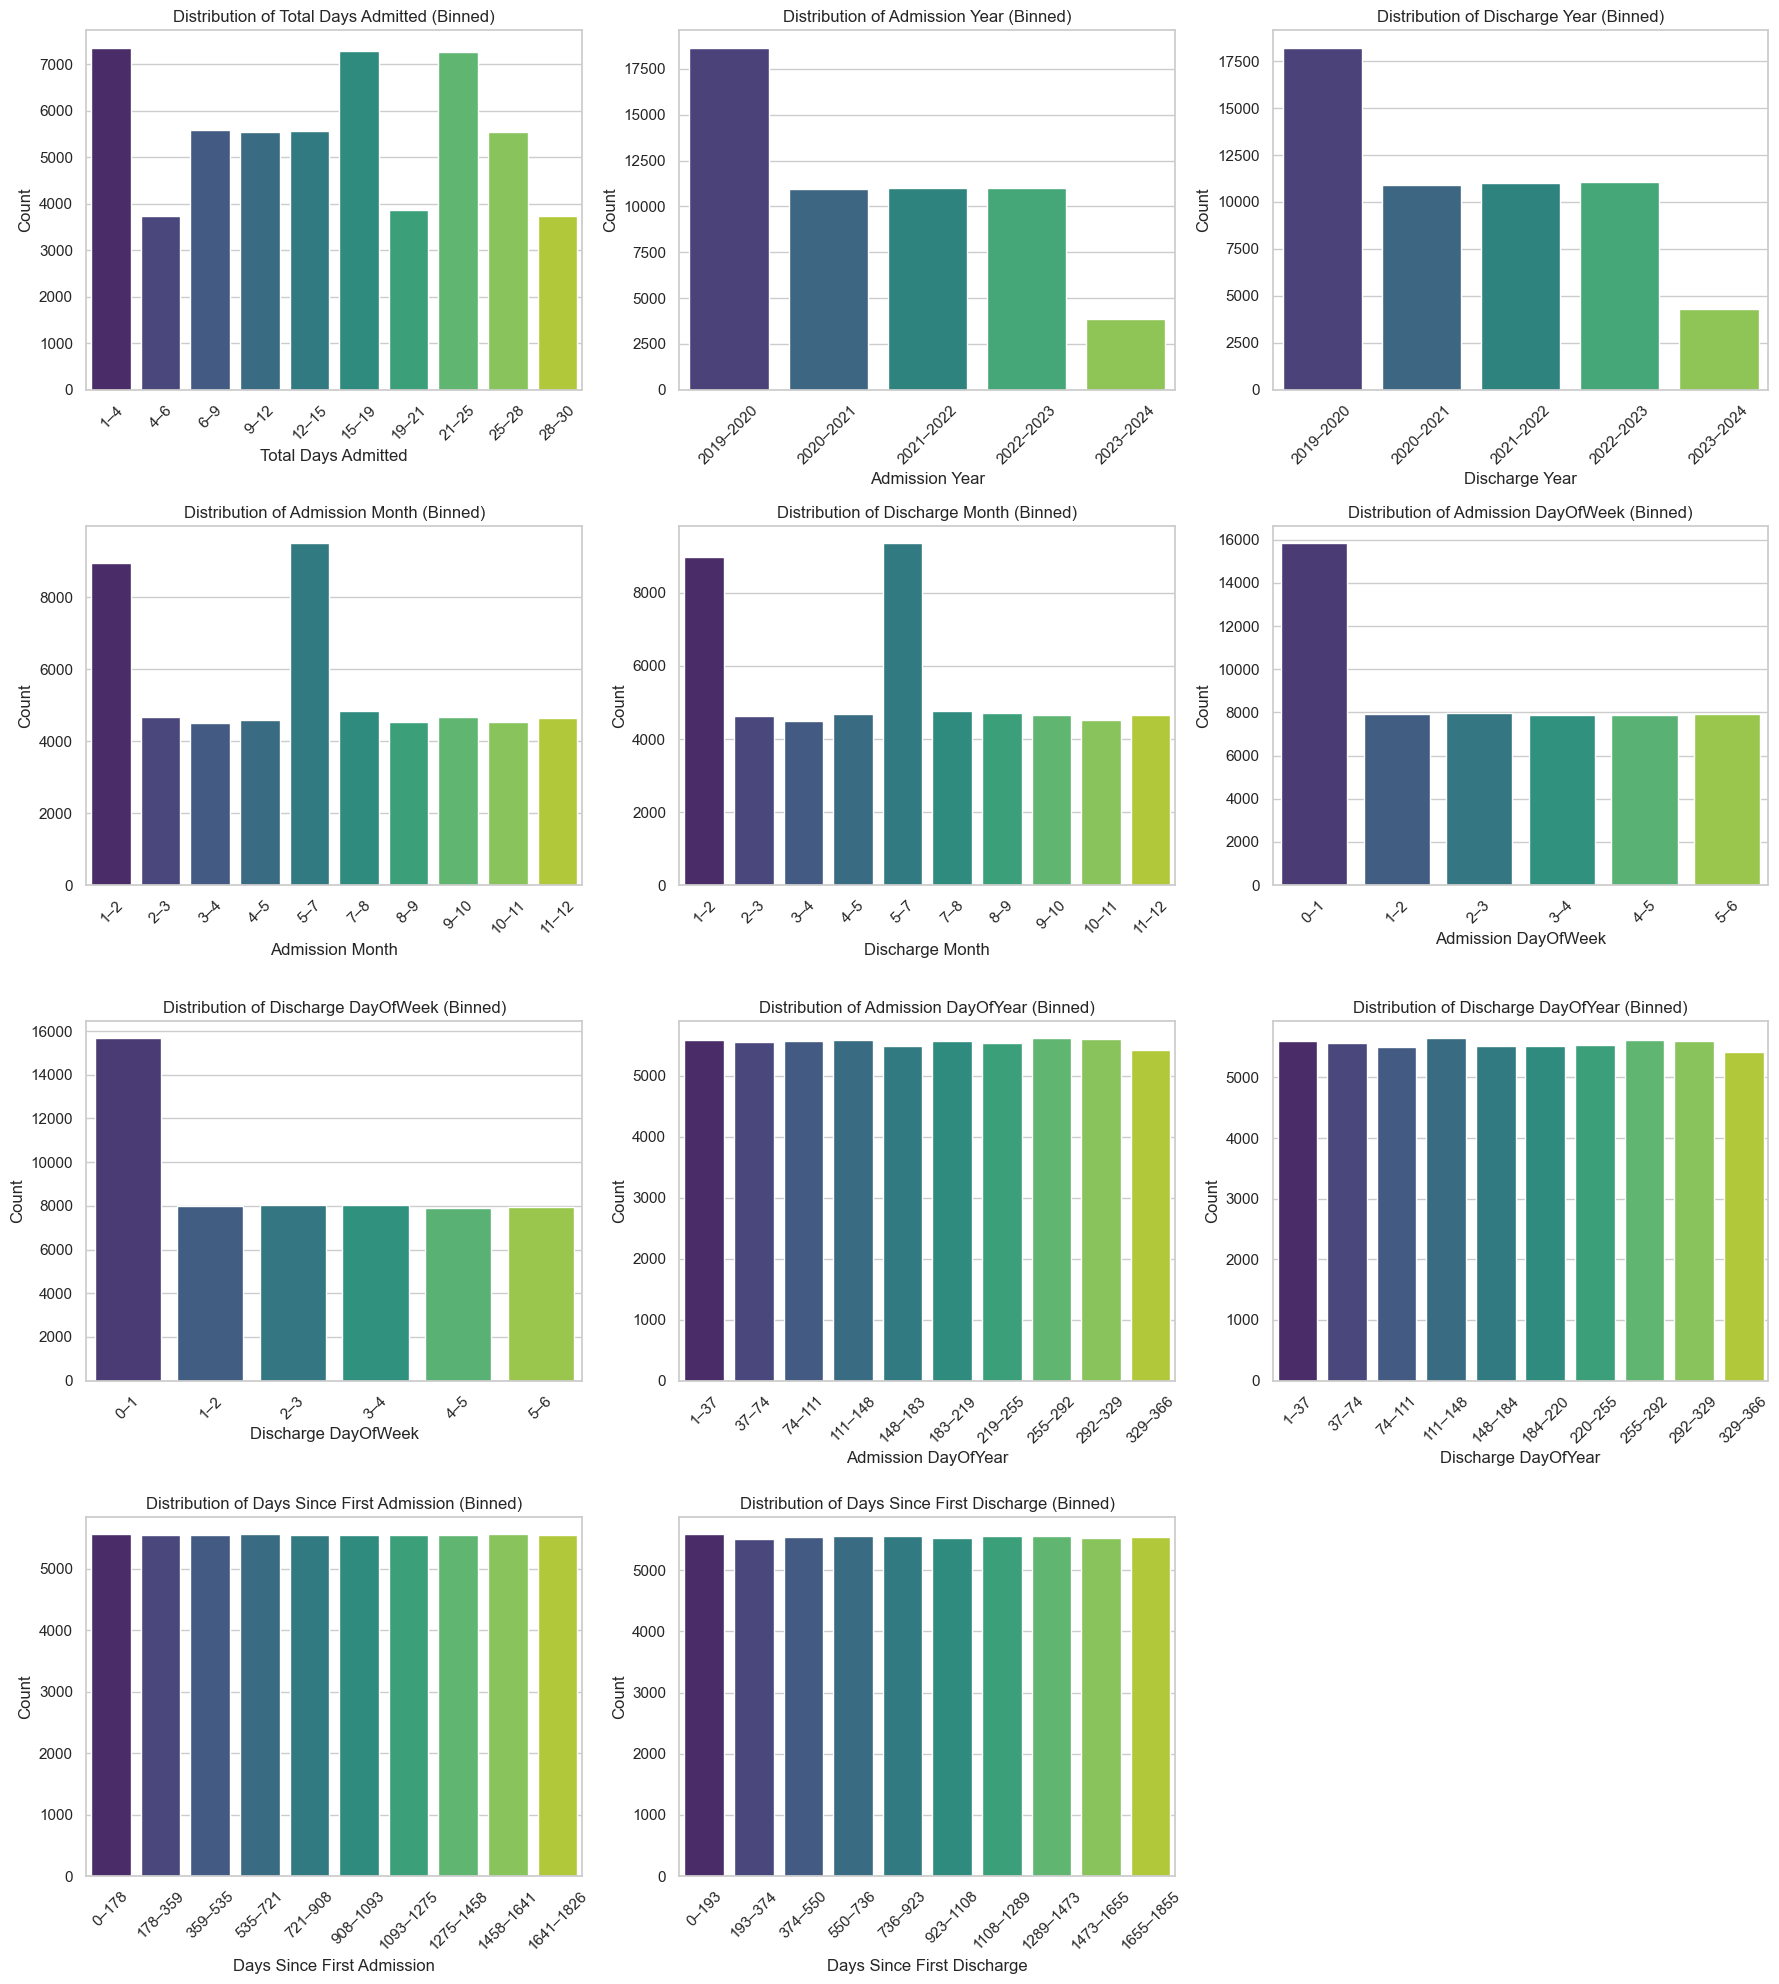

In [75]:
cat_cols = features.select_dtypes(include=['object', 'category']).columns
num_cols = features.select_dtypes(include=['number']).columns  # numeric columns to bin

n_cols = 3
n_rows = int(np.ceil((len(cat_cols) + len(num_cols)) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Function to automatically create bins for numeric columns using quantiles
def bin_numeric_series(series, n_bins=10):
    bins = np.quantile(series.dropna(), np.linspace(0, 1, n_bins + 1))
    bins = np.unique(bins)  # remove duplicates if any quantiles equal
    labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(len(bins)-1)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True, duplicates='drop')

for i, col in enumerate(list(cat_cols) + list(num_cols)):
    if col in ["Doctor", "Hospital"]:
        # Count patients per doctor/hospital
        counts = features.groupby(col).size().reset_index(name="Patient Count")

        # Bin counts for Doctor/Hospital
        max_count = counts["Patient Count"].max()
        bins = [0, 1, 5, 10, 20, 50, 100, 500, 1000, max(max_count + 1, 1001)]
        labels = ["1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–500", "501–1000", "1000+"]

        counts["Bin"] = pd.cut(counts["Patient Count"], bins=bins, labels=labels, right=True)
        bin_counts = counts["Bin"].value_counts().sort_index()

        sns.barplot(
            x=bin_counts.index,
            y=bin_counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} by Patient Count")
        axes[i].set_xlabel(f"Patients per {col}")
        axes[i].set_ylabel(f"Number of {col}s")
        axes[i].tick_params(axis='x', rotation=45)

    elif col in num_cols:
        # Bin numeric columns
        binned = bin_numeric_series(features[col], n_bins=10)
        counts = binned.value_counts().sort_index()

        sns.barplot(
            x=counts.index.astype(str),
            y=counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} (Binned)")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

    else:
        # For small cardinality categorical variables
        counts = features[col].value_counts().reset_index()
        counts.columns = [col, "Count"]

        sns.barplot(
            x=col,
            y="Count",
            data=counts,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()